# SCA using deep learning

After collecting, preprocessing and labeling training data, it is time to train the model on that data. Without delving too deep in the concrete NN architecture, basic concept is that the network receives N inputs (where N is length of power traces) and predicts probabilities for 256 classes (for each of the key byte possibilities). Ideally, model would correctly predict intermediate values in this step, that is, using only 1 trace, but this is almost never the case. In order to make a correct guess, more traces are needed: probabilities for each trace predictions are added together and the one with the largest value is chosen. NOTE: It's important to use softmax activation on the last layer in order to allow for accumulating predictions across different traces. Another advantage of accumulating probabilities is that the result is an orded list of most likely key bytes. That allows for a fallback strategy if the first byte guess was wrong: just use brute force to go trough the list. If the model was able to predict intermediate values better than random, this will work.

All of this is only for one single key byte which means that 16 models will have to be trained in order to recover the whole key. Nevertheless, in the majority of this project, only single attack byte will be attacked because of computation time saving. Once some reasonably good architecture is found, training will be done on all of the key bytes.

# Neural network architectures

A couple of different NN architectures will be tried and tested. Basic multilayer perceptron will be a first choice since it is easy to define and train. As already mentioned, NNs should be able to learn latent features of the data themselves without any human input. Convolutional neural networks proved quite effective in learning distinctive features from images, and that is one of the reasons why CNNs could be used for the SCA. Since power traces are in time series format, 1D convolutions are going to be used.


### Metrics used for model evaluation

**Key rank** is a commonly used metric in SCA. This metric is determined as a 'distance' of the correct key byte from the first element of probability list. Values are in the range of 0, 256 (2^8 byte possibilities). If the model guessed correctly, correct key byte will be first in the probability list; it's distance from the first element is 0. If model was wrong, this distance will be greater than zero. This implies that best models try to lower the key rank as fast as possible. In the rest of this project, key ranks will be calculated and plotted whenever evaluating performance of trained models.

Model predictions are calculated probabilities for the key guesses from 0x00 - 0xFF:
```
#                    0    1      2             23          42
model_predictions = [0.2, 0.001, 0.0058, ... , 0.16, ... , 0.35 , 0.00021]
```
Where probability at the index 0 is probability that the key byte is 0, probability at the index 1 is probability that the key byte is 1 etc.
If the correct key byte is, for example, 0x23, then the probability in `model_predictions` at the index 0x23 shoul have the greatest value. This is usualy not the case when using single trace for prediction. If the indices at which the largest probabilities in `model_predictions` are sorted:

```
# from example above:
#
#                         ____
#                        v    |
argmax_indices_sorted = [42, 23, 57, 73, ....]
```

In this example, **key rank** is the distance of the element 23 from the first element, which is 1. 
Good models will generally produce low key ranks quickly (probability of the correct key byte will be large, which means that correct key will be close to the beginning of the `argmax_indices_sorted)` list.

Some other metrics are:
* **minimal** number of traces needed to recover the full key
* **maximal** number of traces needed to recover the full key
* **average** number of traces needed to recover the full key (across multiple traces)
* modified version of the AUC: *success rate as a function of the number of traces used*

## MLP (multi-layered perceptron)

Multilayer perceptron is one of the simplest feed forward neural network architectures. It consists of multiple layers with nonlinear activations. Model weights are learned trough backpropagation (exact type of optimizer is a hyperparameter). Other hyperparameters are number of layers, number of neurons (units) in each layer, learning rate for optimizer.

Model described in the [ASCAD paper]() will be used as a starting point in developing optimal architecture.

In [6]:
%load_ext autoreload
%autoreload 2

In [5]:
import random
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import os
import numpy as np
import h5py
import tensorflow as tf
import keras
from datetime import datetime
import keras_tuner as kt
from tqdm.notebook import tqdm
import tensorflow_addons as tfa

Import utility packages

In [7]:
from utils.data_preparation import SCAML_Dataset
from utils.AES import AES
from utils.training import SCA_Trainer

In [8]:
EXECUTE_IN_COLAB = False
ATTACK_ALGORITHM = 'tinyaes'

if EXECUTE_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    colab_root_path = '/content/drive/MyDrive/'
    
    training_data_path = colab_root_path + 'datasets/tinyaes/train'
    testing_data_path = colab_root_path + 'datasets/tinyaes/test'
    
    save_models_root_path = colab_root_path + 'models/'
    
    log_root_path = colab_root_path + 'logs/'
else:
    data_root_path = './data/SCA_datasets/datasets/' + ATTACK_ALGORITHM
    
    training_data_path = data_root_path + '/train'
    testing_data_path = data_root_path + '/test'
    
    save_models_root_path = './models/'
    
    log_root_path = './logs/'

### Load SCAAML dataset

In [5]:
dataset = SCAML_Dataset()

In [6]:
dataset.create_dataset(training_data_path, attack_point='sub_bytes_out', trace_length=20000)
dataset.create_dataset(testing_data_path, attack_point='sub_bytes_out', attack=True, trace_length=20000)

256it [00:01, 154.17it/s]
Loading shards: 100%|█| 256/256 [00:49<00:00,  5.22it
256it [00:01, 140.37it/s]
Loading shards: 100%|█| 256/256 [00:49<00:00,  5.16it


In [10]:
training_data = dataset.get_profiling_dataset(attack_byte=0)

#NOTE: attack data is not needed except when attacking
# attack_data = dataset.get_attack_dataset(attack_byte=0)

In [11]:
training_data.X.shape
training_data.y.shape

TensorShape([65536, 256])

In [75]:
(X_profiling, y_profiling) = training_data.X, training_data.y

#NOTE: attack data is not needed except when attacking
# (X_attack, y_attack, keys, plaintexts) = attack_data.X, attack_data.y, attack_data.keys, attack_data.plaintexts

In [ ]:
input_vector_shape = X_profiling.shape[1]

In [77]:
X_profiling.shape, y_profiling.shape

(TensorShape([65536, 20000, 1]), TensorShape([65536, 256]))

### Create and train vanilla MLP

After loading the data, basic multi layer perceptron is trained. The architecture is based on the architecture described in [ASCAD paper](https://eprint.iacr.org/2018/053.pdf).

In [150]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, activation='relu')(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, activation='relu')(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP = keras.Model(inputs=inputs, outputs=outputs, name='MLP_base_SCAAML')

MLP.summary()

Model: "MLP_base_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               3000200   
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_4 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_5 (Dense)      (None, 200)               40200     
                                                                 
 output_layer (Dense)        (None, 256)           

In [151]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

Similar function is defined in utils.training (SCAML_Trainer.train_model), but this one is kept as an example of internal steps of that function. In the rest of this notebook, function from utils package will be used.

In [ ]:
_time = datetime.now().strftime("%Y-%d-%m_%H-%M")

_log_dir = log_root_path + 'MLP_' + _time

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1)
]

history = MLP.fit(X_profiling, y_profiling, batch_size=32, epochs=50, verbose=1, validation_data=(X_attack, y_attack), callbacks=callbacks_list)

MLP.save(save_models_root_path + MLP.name + _time)

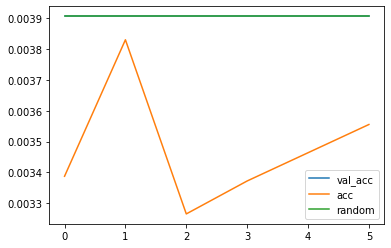

In [153]:
random_accuracy = [1/256] * len(history.history['val_accuracy'])

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(random_accuracy)
plt.legend(['val_acc', 'acc', 'random'],loc='best')
plt.show()

Training was stopped after 5 epochs because validation loss didn't decrease for two consecutive eopchs (EarlyStopping callback).
This model performed really bad, it's even worse than random baseline (1/256 ~0.0039). The accuracy itself doesn't need to be perfect, but it has to be better than random. The reason this model behaved this poorly is probably the huge resolution of input traces (which is much larger than in ASCAD paper).

### Batch normalization

In theory, [batch normalization](https://arxiv.org/pdf/1502.03167v3.pdf) layers should help to smoothen loss function and speed up the training process. It is shown that it also stabilizes training and helps with gradient explosion/vanishing. It can also allow for bigger learning rates which can also speed up the training.

In [11]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP_batchnorm = keras.Model(inputs=inputs, outputs=outputs, name='MLP_batch_norm_SCAAML')

MLP_batchnorm.summary()

Model: "MLP_batch_norm_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               3000200   
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_4 (Dense)      (None, 200)               40200     
                                             

In [12]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_batchnorm.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [ ]:
_time = datetime.now().strftime("%Y-%d-%m_%H-%M")

_log_dir = log_root_path + 'MLP_batchnorm_' + _time

checkpoint_filepath = './checkpoints/' + MLP_batchnorm.name + '_' + _time

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)
]

history = MLP_batchnorm.fit(X_profiling, y_profiling, batch_size=32, epochs=50, verbose=1, validation_split=0.2, callbacks=callbacks_list)

MLP_batchnorm.save(save_models_root_path + MLP_batchnorm.name + _time)

In [15]:
MLP_batchnorm.save(save_models_root_path + MLP_batchnorm.name + _time)

INFO:tensorflow:Assets written to: ./models/MLP_batch_norm_SCAAML2022-24-08_15-22\assets


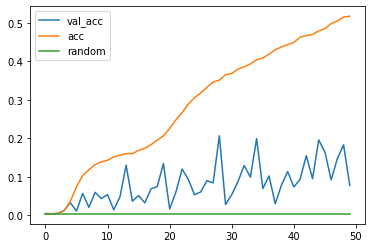

In [14]:
MLP_batchnorm.plot_model_history()

The model is making good predictions on training set, but validation accuracy is fluctuating a lot. This could mean that the model overfitted training data, and that some regularization should take place during training. It makes sense to try and evaluate this model's performance since both training and validation accuracies are better than random. Both precision *and* number of traces impact model's ability to extract hwardware secrets in the end.

### Evaluate the model

The model is evaluated on the attack traces and a single byte. Since attack dataset consists of 256 'shards' each containing 256 traces, shuffling is not allowed, and each shard represents a different key. 

### Model evaluation API

Functions for model evaluation are a part of SCA_Trainer class and are defined within training.py module. For this notebook's brevity, only high level API will be given here. Implementation details can be found in the source code of the module itself.

``` python
        train_model(self, 
                    model,
                    dataset,
                    attack_byte,
                    batch_size,
                    epochs,
                    validation_split=0.0,
                    validation_data=None,
                    callbacks_list=None,
                    tag='',
                    save_dir='',
                    verbose=1):
        """! Model training wrapper function.

        Train the model, plot training data on Tensorboard and save trained model to specified path.

        @param model Model to train
        @param X_train Model inputs
        @param y_train Correct labels
        @param batch_size Size of the input batch
        @param epochs Number of epochs to train
        @param validation_split Percentage of data from training set to use for validation
        @param callbacks_list List of tf callbacks to use during training, default are EarlyStopping and Tensorboard
        @param tag Additional info regarding training details, default is none
        @save_dir Path to save model to, default is './models
        """
```

```python
        evaluate_model(self,
                       model,
                       dataset,
                       attack_byte,
                       traces_per_chunk=256,
                       keys_to_attack=256,
                       verbose=1):
        """! Evaluate model quality based on SCA relevant metrics.
        This is equivalent to attacking single key byte (of possibly many different keys).
        Accuracy and key rank metrics are calculated during evaluation.

        @param model Trained Keras model object to evaluate
        @param dataset Dataset on which to perform evaluation
        @param attack_byte Key byte index to attack (0 - 15)
        @param traces_per_chunk Number of traces in each attack chunk. All the data in one attack chunk is regarding the same key.
        @param keys_to_attack Number of different keys to attack. Equivalent to number of shards to attack.
        @param verbose Print extra information during evaluation if 1. 1 by default 
        """
```

In [ ]:
key_ranks = []
y_predicted_list = []
y_true_list = []
stats_per_trace = {}

dataset_batchnorm = dataset

batchNormTrainer = SCA_Trainer()
batchNormTrainer.evaluate_model(MLP_batchnorm, dataset=dataset_batchnorm, attack_byte=0, traces_per_chunk=256, keys_to_attack=20, verbose=1)

In [ ]:
batchNormTrainer.evaluation_summary()

### Regularization

Since it seems that model iis overfitting training data, couple of regularization techniques will be tested. 

#### Dropout

Artificially "turn off" portion of neurons to avoid overfitting.

In [81]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1',
                       units=200,
                       activation='relu')(inputs)

# Dropout layer 1
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2',
                       units=200,
                       activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3',
                       units=200,
                       activation='relu')(x)

# Dropout layer 2
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4',
                       units=200,
                       activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5',
                       units=200,
                       activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer',
                             units=256,
                             activation='softmax')(x)

MLP_dropout = keras.Model(inputs=inputs,
                            outputs=outputs,
                            name='MLP_Dropout')

MLP_dropout.summary()

Model: "MLP_batch_norm_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               4000200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 batch_normalization_3 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                             

In [83]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_dropout.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [ ]:
dropout_trainer = SCA_Trainer()

dropout_trainer.train_model(MLP_dropout, dataset, ATTACK_BYTE, batch_size=32, epochs=50, validation_split=0.2, tag='rate=0.2')

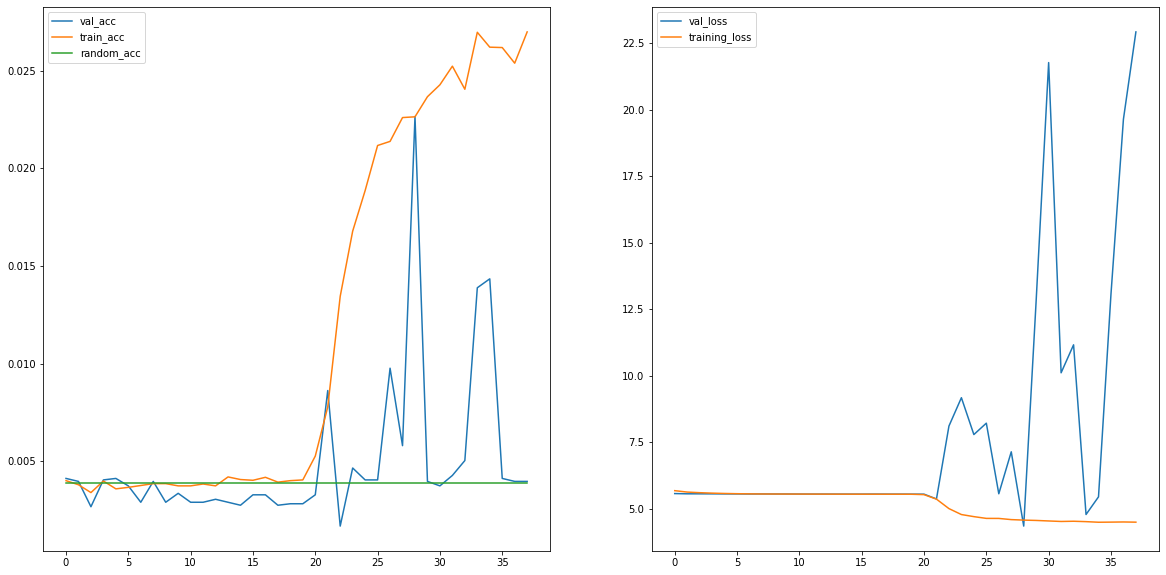

In [90]:
dropout_trainer.plot_model_history()

The model failed to learn anything and training was interrupted because of loss stagnation. The reason could be that there is not enough neurons in hidden layers and with the dropout applied, it performs even worse. Since the validation accuracy is pretty close to random, model probably won't be able to guess anything.

Since BatchNorm paper mentions that BatchNorm can replace Droput:

>Batch Normalization fulfills some of the same goals as Dropout. Removing Dropout from Modified BN-Inception speeds up
training, without increasing overfitting.

The fact that both of these methods were tried out could be the reason for model's  poor performance.

  0%|          | 0/256 [00:00<?, ?it/s]

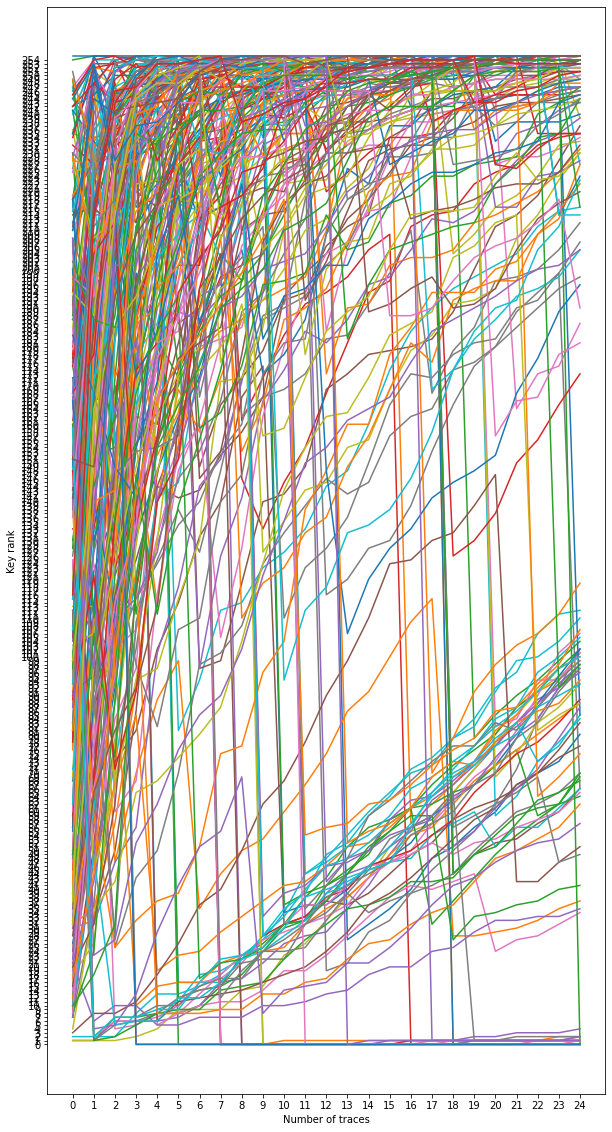

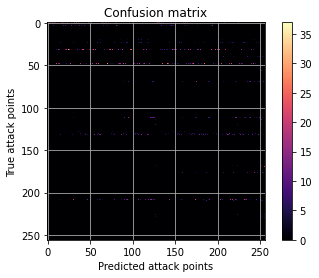

In [94]:
dropout_trainer.evaluate_model(MLP_dropout, dataset, attack_byte=ATTACK_BYTE, traces_per_chunk=25, verbose=0)

From the confusion matrix, it's obvious that model is predicting completely randomly, and the plot of key ranks is pretty bad.

In [101]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1',
                       units=5000,
                       activation='relu')(inputs)

# Dropout layer 1
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2',
                       units=2500,
                       activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3',
                       units=2000,
                       activation='relu')(x)

# Dropout layer 2
x = keras.layers.Dropout(rate = 0.2)(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4',
                       units=1000,
                       activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5',
                       units=500,
                       activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer',
                             units=256,
                             activation='softmax')(x)

MLP_dropout_v2 = keras.Model(inputs=inputs,
                            outputs=outputs,
                            name='MLP_Dropout_v2')

MLP_dropout_v2.summary()

Model: "MLP_Dropout_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 5000)              100005000 
                                                                 
 dropout_2 (Dropout)         (None, 5000)              0         
                                                                 
 hidden_layer_2 (Dense)      (None, 2500)              12502500  
                                                                 
 batch_normalization_5 (Batc  (None, 2500)             10000     
 hNormalization)                                                 
                                                                 
 hidden_layer_3 (Dense)      (None, 2000)              5002000   
                                                    

In [102]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_dropout_v2.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [ ]:
dropout_trainer_v2 = SCA_Trainer()

dropout_trainer_v2.train_model(MLP_dropout, dataset, ATTACK_BYTE, batch_size=32, epochs=50, validation_split=0.2, tag='rate=0.2_moreNeurons')

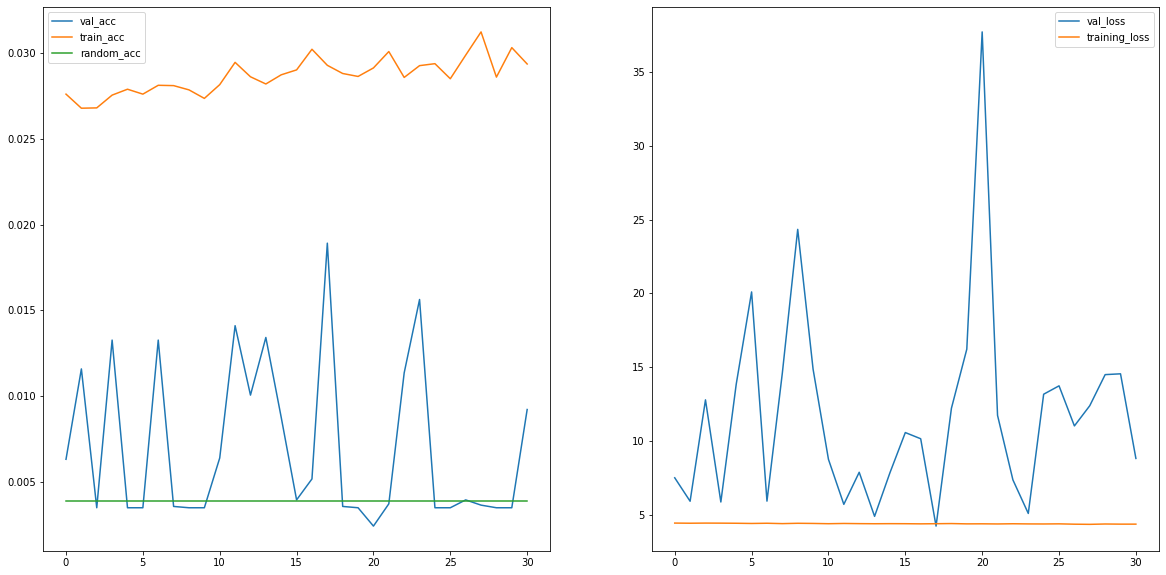

In [105]:
dropout_trainer_v2.plot_model_history()

Adding dropout doesn't help the network accuracy, and even makes it worse apparently. Large number of input points and the fact that dropout shuts down some of the neurons could be the reason for this.

#### L1 and L2 regularization

Try to use L1 and L2 regularizations with no dropouts to see if the network generalizes better.

In [ ]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP_regularization = keras.Model(inputs=inputs, outputs=outputs, name='MLP_regularization')

MLP_regularization.summary()

In [116]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

MLP_regularization.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

reg_trainer = SCA_Trainer()

In [ ]:
reg_trainer.train_model(MLP_regularization, dataset, ATTACK_BYTE, batch_size=32, epochs=50, validation_split=0.2, verbose=0)

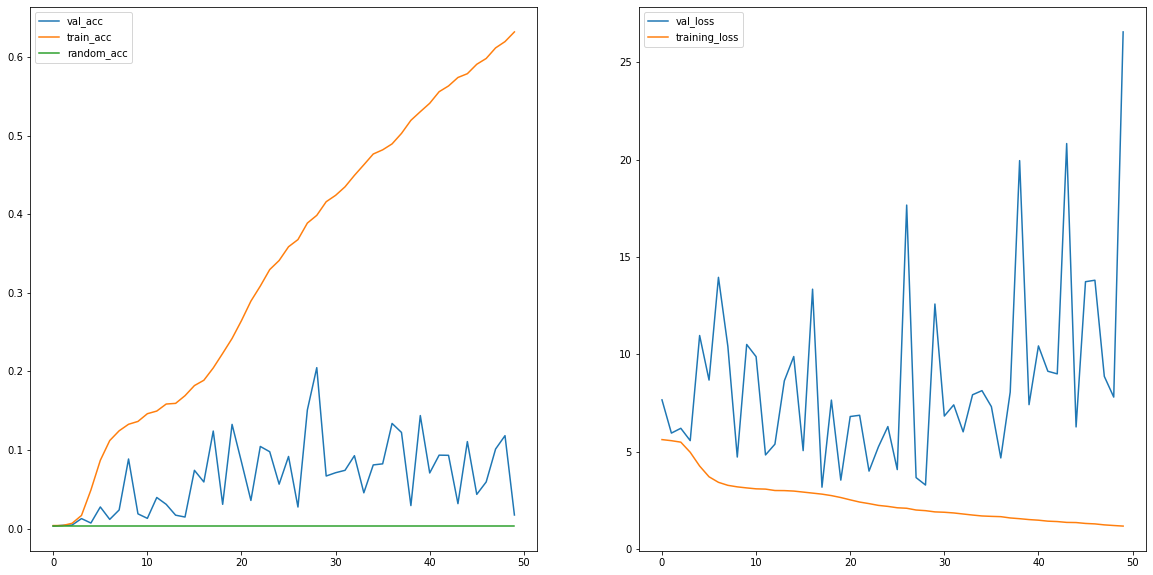

In [118]:
reg_trainer.plot_model_history()

Even though training accuracy is constantly rising, validation accuracy is fluctuating around random baseline. Nevertheless, it can still be evaluated on the attack dataset.

  0%|          | 0/10 [00:00<?, ?it/s]

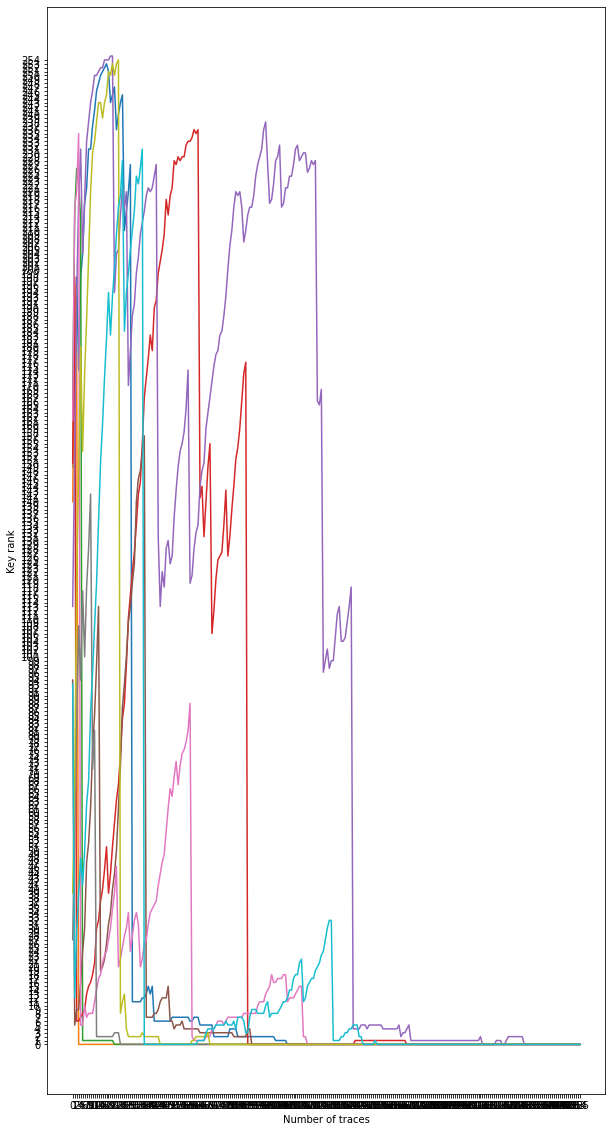

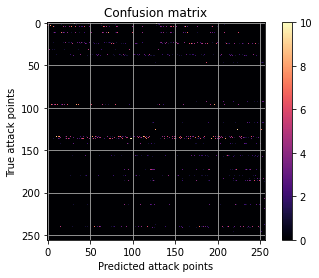

In [138]:
dropout_trainer.evaluate_model(MLP_dropout, dataset, attack_byte=ATTACK_BYTE, traces_per_chunk=256, verbose=0, keys_to_attack=10)

Even though there is no discernable diagonal of the confusion matrix (which would be the case if the model was more accurate), this model was able to crack all of the key bytes with enough traces. More accurate models would be able to do this using less traces.

Maximum accuracy of 100.0 achieved with 206 traces


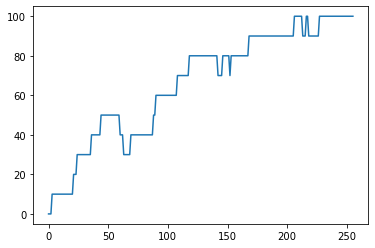

In [141]:
dropout_trainer.evaluation_summary()

Model was able to correctly guess all of the keys using 206 traces per key and that shows accuracy is not the main metric here.

This being said, the goal is to achieve 100% guess accuracy using less traces.

## Hypertuning

The results of ad-hoc model constructions are okay, but in order to achieve greater accuracy and key recovery, optimal hyperparameters should be used. Instead of guessing how each hyperparameter can affect the attack success, hyper tuning using Keras tuner will be applied.


[Keras tuner](https://keras.io/api/keras_tuner/)
[Kares tuner quick intro](https://www.youtube.com/watch?v=O85gh3OzluI)

Two types of Keras tuner classes will be used:

* Random search
* Hyperband

Search results and logs are saved in `hyperparam_tuning` folder.

In [32]:
min_layers = 4
max_layers = 10

min_units = 50
max_units = 1000

# Meta model builder
def build_model(hp):
    
    inputs = keras.Input(shape = (input_vector_shape,))
    
    x = inputs
    
    no_layers = hp.Int('num_layers', min_value=min_layers, max_value=max_layers)
    for layer in range(no_layers):
        
        x = keras.layers.Dense(units = hp.Int('units', min_value=min_units, max_value=max_units, step=50),
                               activation = 'relu')(x)
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and hp.Boolean('BatchNormalize'):
            x = keras.layers.BatchNormalization()(x)
        

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 3e-2, 3e-3, 3e-4, 3e-5, 5e-2, 5e-3, 5e-4, 5e-5])

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

#### RandomSearch

In [ ]:
r_tuner = kt.RandomSearch(hypermodel=build_model,
                    objective='val_accuracy',
                    max_trials=30,
                    executions_per_trial=1,
                    directory=log_root_path + '/hyperparam_tuning/RandomSearch')

r_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./logs//hyperparam_tuning/RandomSearch\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./logs//hyperparam_tuning/RandomSearch\untitled_project\tuner0.json
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [ ]:
tensorboard_path  = log_root_path + '/hyperparam_tuning/RandomSearch'

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

r_tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )

Search was interrupted after 3.5 hours and the best validation accuracy was 0.143:



#### Hyperband

In [30]:
training_data = dataset.get_dataset(attack_byte=0, training=True, trace_length=20000)

In [33]:
training_data.X.shape, training_data.y.shape
input_vector_shape = 20000 #TODO: remove magicnum

In [34]:
h_tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=5,
    directory=log_root_path + '/hyperparam_tuning/Hyperband_v2',
)

h_tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [35]:
X_train = training_data.X
y_train = training_data.y

In [ ]:
tensorboard_path  = log_root_path + '/hyperparam_tuning/Hyperband' + datetime.now().strftime("%Y-%d-%m_%H-%M")

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

h_tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_split=0.2, 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )

Search was interrupted after 5 hours when acceptable validation accuracy of 0.146 was found:



### Construct MLP using best hyperparameters

Hyperband search achieved slightly better validation accuracy (0.146 versus 0.143 for RandomSearch). After tuning is done, model with best hyperparameters is compiled and trained completely.

In [54]:
best_hyperparams = h_tuner.get_best_hyperparameters()[0]
best_hyperparams.values

{'num_layers': 9,
 'units': 750,
 'BatchNormalize': True,
 'learning_rate': 3e-05,
 'tuner/epochs': 75,
 'tuner/initial_epoch': 25,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '5d8aa389c17eeb4756d9becafad1a8b8'}

In [47]:
best_MLP = h_tuner.hypermodel.build(best_hyperparams)
best_MLP.save(save_models_root_path + 'BestMLP_Hyperband' + datetime.now().strftime("%Y-%d-%m_%H-%M"))

INFO:tensorflow:Assets written to: ./models/BestMLP_Hyperband_test2022-31-08_08-09\assets


Visualize best model architecture:

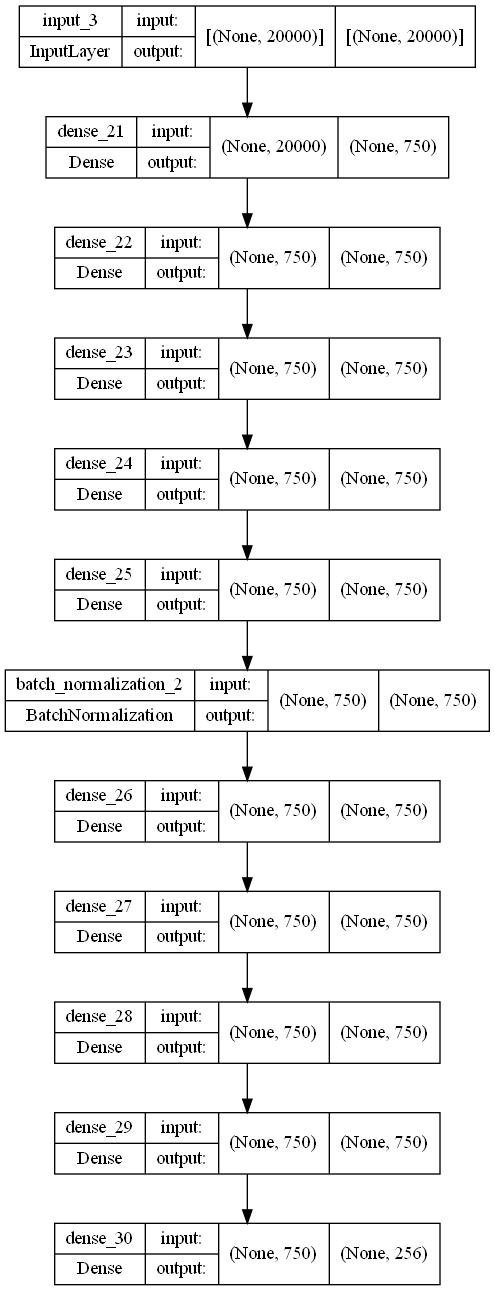

In [56]:
tf.keras.utils.plot_model(best_MLP, show_shapes=True)

Hypertuning progress can be interactively visualized and summarized using Tensorboard:

In [79]:
%load_ext tensorboard
%tensorboard --logdir ./logs/hyperparam_tuning/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Run full training on best MLP

In [17]:
best_MLP = tf.keras.models.load_model(save_models_root_path + 'BestMLP_Hyperband2022-27-08_12-01')

In [ ]:
ATTACK_POINT = 'sub_bytes_out'
ATTACK_BYTE = 0

trainer = SCA_Trainer()

trainer.train_model(best_MLP, dataset, attack_byte=ATTACK_BYTE, batch_size=32, epochs=25, validation_split=0.2, tag='Hypertuner_BestMLP')

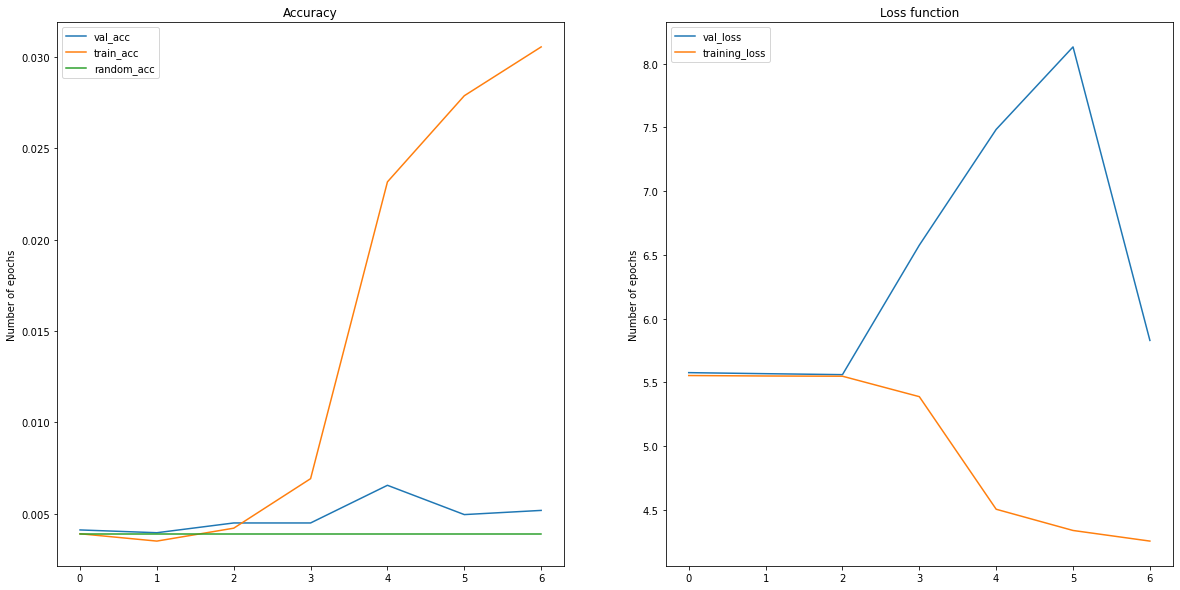

In [22]:
trainer.plot_model_history()

With this model's poor accuracy, it's expected that the number of traces needed to recover the key byte will be large. Evaluation is given below:

### Evaluate best MLP

In [24]:
s = SCA_Trainer()

  0%|          | 0/50 [00:00<?, ?it/s]

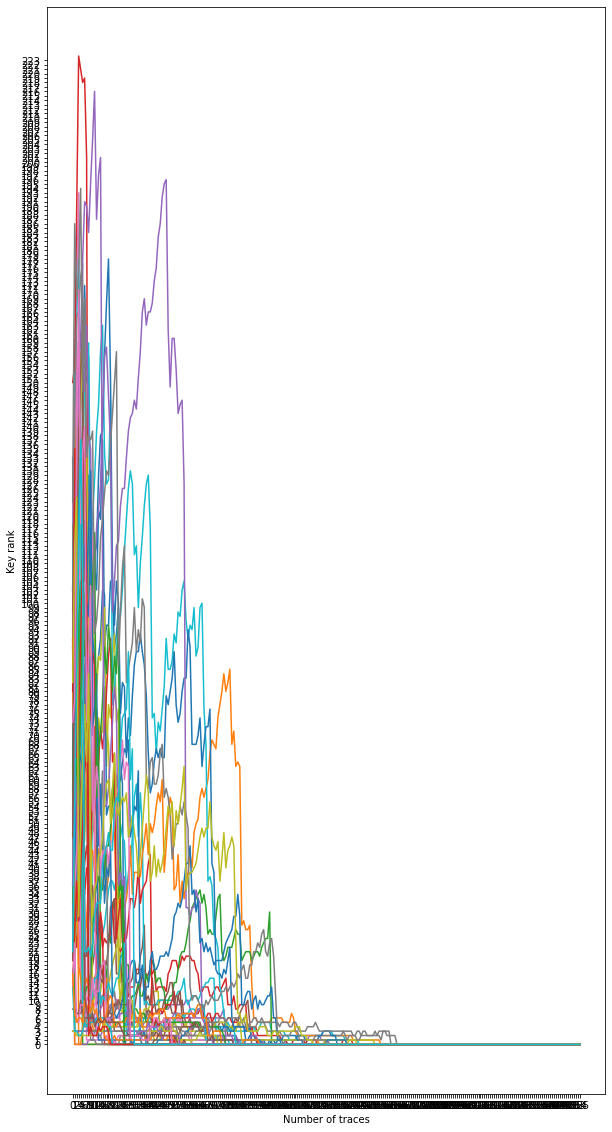

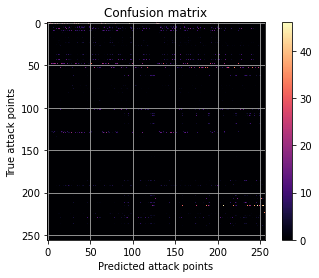

In [26]:
s.evaluate_model(best_MLP,
                 dataset,
                 attack_byte=ATTACK_BYTE,
                 traces_per_chunk=256, # Because of the model's poor accuracy, more traces are needed
                 keys_to_attack=50,
                 verbose=0)

As expected, model was able to recover the key byte, but 163 traces were needed, which is far from ideal. 

Model achieved average accuracy of 1.2% on 50 different keys (256 traces each)
Maximum key recovery success of 100.0 achieved with 163 traces


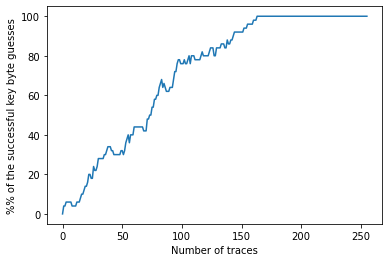

In [29]:
s.evaluation_summary()

Even with horrible classification accuracy, model was able to crack all of the keys with 163 traces.

### Compare best MLP with SCAAML pretrained CNN

Make sure to evaluate both models on the first key byte:

In [7]:
ATTACK_BYTE = 0

#### Evaluate pretrained SCAAML model

In [81]:
scaaml_model_path = "./models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_20000"
scaaml_pretrained = tf.keras.models.load_model(scaaml_model_path)

In [13]:
scaaml_pretrained_trainer = SCA_Trainer()

  0%|          | 0/50 [00:00<?, ?it/s]

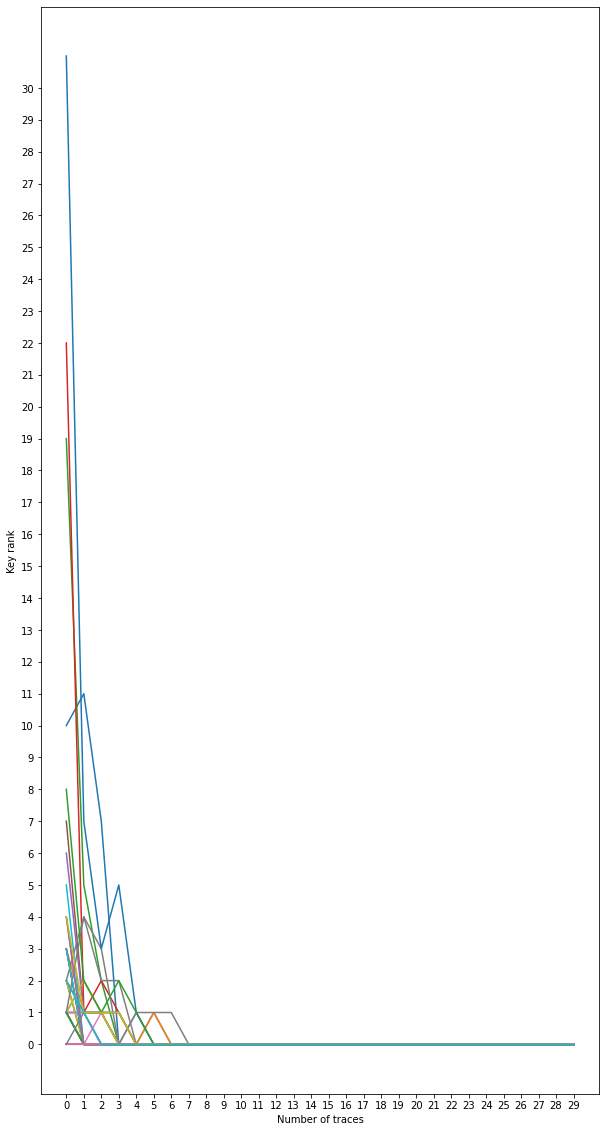

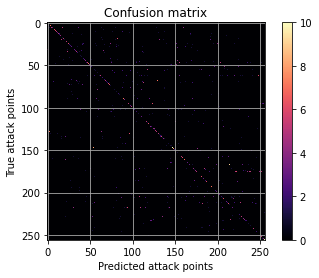

In [16]:
scaaml_pretrained_trainer.evaluate_model(scaaml_pretrained,
                 dataset,
                 attack_byte=ATTACK_BYTE,
                 traces_per_chunk = 30,
                 keys_to_attack=50,
                 verbose=0)

Model achieved average accuracy of 9.22% on 50 different keys (30 traces each)
Maximum key recovery success of 100.0 achieved with 7 traces


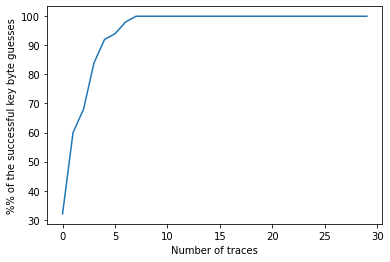

In [17]:
scaaml_pretrained_trainer.evaluation_summary()

It is obvious that the best MLP is worse than pretrained CNN, which was expected based on their relative accuracies. Nevertheless, simple MLP was also able to crack the key and could be used against unprotected AES implementations.

## Train MLPs to recover the whole key

Since 1 model is not enough to recover all the key bytes, 15 more models have to be trained. This is how the real-world attack would look like after capturing traces of the targeted device.

In [34]:
input_vector_shape = 20000

In [35]:
# Reload saved hypertuner

h_tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=5,
    directory=log_root_path + '/hyperparam_tuning/RandomSearch',
)

h_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./logs//hyperparam_tuning/RandomSearch\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./logs//hyperparam_tuning/RandomSearch\untitled_project\tuner0.json
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [36]:
best_hyperparams = h_tuner.get_best_hyperparameters()[0]
best_hyperparams.values

{'num_layers': 9,
 'units': 750,
 'BatchNormalize': True,
 'learning_rate': 3e-05,
 'tuner/epochs': 75,
 'tuner/initial_epoch': 25,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '5d8aa389c17eeb4756d9becafad1a8b8'}

In [46]:
h_tuner.get_best_models(num_models=1)

In [40]:
# Save best configuration

best_hyperparams_cfg = {'num_layers': 9,
 'units': 750,
 'BatchNormalize': True,
 'learning_rate': 3e-05,}

In [43]:
def build_model_from_config(config):
    
    inputs = keras.Input(shape = (input_vector_shape,))
    
    x = inputs
    
    no_layers = config['num_layers']
    for layer in range(no_layers):
        
        x = keras.layers.Dense(units = config['units'], activation = 'relu')(x)
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and config['BatchNormalize']:
            x = keras.layers.BatchNormalization()(x)
        

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    
    learning_rate = config['learning_rate']

    
    model_name = f'HyperMLP_' \
                 f'{no_layers}_layers_' \
                 f'{str(config["units"])}_units_' + datetime.now().strftime("%Y-%d-%m_%H-%M")
    
    model = keras.Model(name=model_name,
                        inputs=inputs,
                        outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

In [ ]:
full_trainer_list = []
models_list = []

ATTACK_POINT = 'sub_bytes_out'

# Start from 1 because byte 0 model is already trained
for attack_byte in range(1,16):
    m = build_model_from_config(best_hyperparams_cfg)
    
    t = SCA_Trainer()
    t.train_model(m,
                  dataset,
                  attack_byte=attack_byte,
                  batch_size=32,
                  epochs=10,
                  validation_split=0.2,tag=f'FullMLP_byte_{attack_byte}')
    
    models_list.append(m)
    full_trainer_list.append(t)

---

# Deploy full key attack

Load all of the models and perform guesses on all of the 16 key bytes.

In [39]:
import glob

models_list = []
listing = glob.glob('./models/Hyper*[0-9]FullMLP_byte*')

In [41]:
for model_path in listing:
    models_list.append(tf.keras.models.load_model(model_path))

In [25]:
fullAttack = SCA_Trainer()

In [67]:
# For reproducability
random.seed(42)
KEY_INDEX = random.randint(0,256)

In [68]:
# Uncomment for real attack:
#KEY_INDEX = random.randint(0, 256)

# Use all available traces to maximize attack success (better models would need less traces)
TRACES_PER_KEY = 256

fullAttack.attack_full_key(models_list, None, dataset, key_index=KEY_INDEX, traces_per_chunk=TRACES_PER_KEY, verbose=0)

  0%|          | 0/16 [00:00<?, ?it/s]

[57, 185, 196, 241, 226, 117, 146, 57, 201, 160, 71, 26, 247, 144, 65, 157]

Ansamble of trained MLP's was able to recover most of the key bytes, but not all. 81% of the key bytes were correctly predicted. Since it is obvious which models failed, some fine tuning can be done: false predictions were made on bytes 4, 5 and 13 (counting from 0). Models for these bytes should have correct key byte at the top of their prediction lists; This can be checked by inspecting true key byte rank plot.

In [100]:
fine_tuning_trainer = SCA_Trainer()

model_4 = models_list[4]

  0%|          | 0/256 [00:00<?, ?it/s]

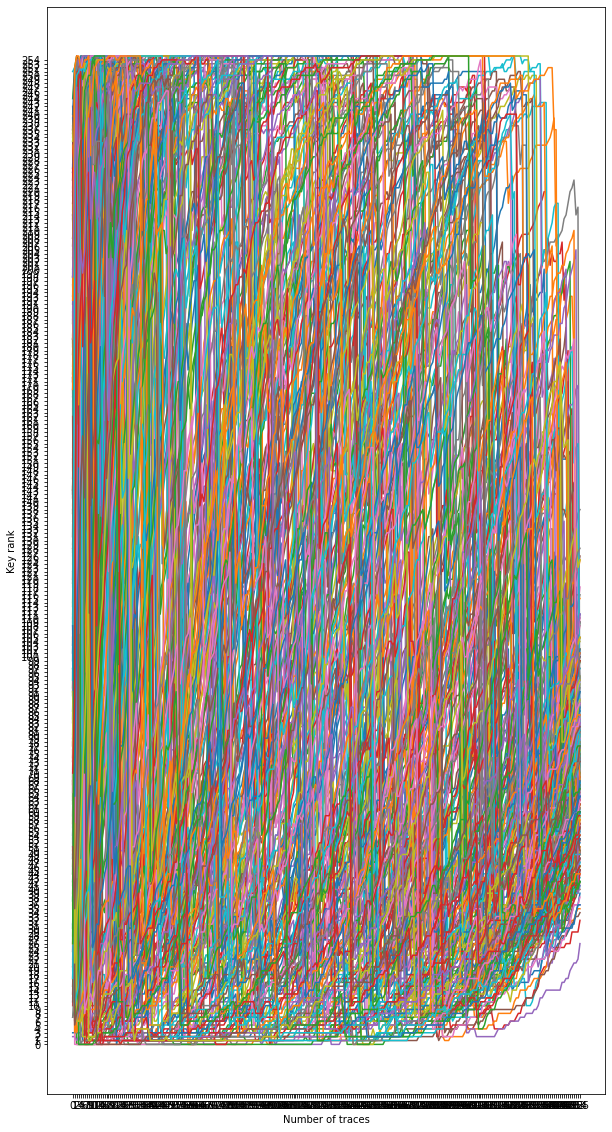

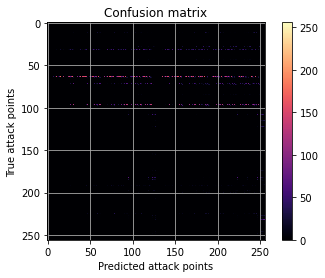

In [101]:
fine_tuning_trainer.evaluate_model(model_4, dataset, attack_byte=4, verbose=0)

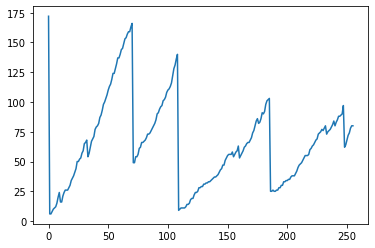

In [111]:
plt.plot(fine_tuning_trainer.key_ranks[204])

In [112]:
# get correct key byte rank
fine_tuning_trainer.key_ranks[204][-1]

80

This means that the brute force search on 4th key byte would give correct prediction after 80 trials. As some form of mitigation, model that predicts fourth key byte could be retrained.